# Método de Newton-Raphson en $\mathbb{R}^4$ (Parte B)

**Autor:** (Nombre del Autor)  
**Fecha:** 27 de octubre de 2025  
**Curso / Laboratorio:** Laboratorio 3 - Optimización

---
## Descripción Breve
Este cuaderno desarrolla una implementación académica y didáctica del método de Newton-Raphson aplicado a una función diferenciable en $\mathbb{R}^4$. Se deriva simbólicamente el gradiente y la Hessiana, se implementa el algoritmo numérico con tratamiento de singularidad/condicionamiento y se analizan resultados de convergencia desde distintos puntos iniciales.

**Función de prueba:**
$$
f(w,x,y,z) = (w-1)^2 + (x-2)^2 + (y-3)^2 + (z-4)^2.
$$
El mínimo global esperado es $\mathbf{x}^* = (1,2,3,4)$.

---


## Introducción
El método de Newton-Raphson para optimización multivariable en $\mathbb{R}^n$ utiliza la expansión de Taylor de segundo orden para aproximar localmente una función diferenciable $f: \mathbb{R}^n \to \mathbb{R}$. A partir de un punto $\mathbf{x}_k$, se construye el modelo cuadrático:
$$
q_k(\mathbf{x}) = f(\mathbf{x}_k) + \nabla f(\mathbf{x}_k)^T (\mathbf{x}-\mathbf{x}_k) + \tfrac{1}{2}(\mathbf{x}-\mathbf{x}_k)^T H(\mathbf{x}_k) (\mathbf{x}-\mathbf{x}_k),
$$
y minimizando $q_k$ se obtiene la dirección de Newton resolviendo:
$$
H(\mathbf{x}_k)\, \mathbf{p}_k = \nabla f(\mathbf{x}_k), \qquad \mathbf{x}_{k+1} = \mathbf{x}_k - \mathbf{p}_k.
$$
Este cuaderno aplica el método a una función cuadrática estrictamente convexa en cuatro variables y analiza convergencia, estabilidad numérica y efectos del punto inicial.


## Desarrollo Teórico
Sea la función objetivo definida por:
$$
f(w,x,y,z) = (w-1)^2 + (x-2)^2 + (y-3)^2 + (z-4)^2.
$$
Es una función cuadrática estrictamente convexa porque su Hessiana es definida positiva.

### 1. Gradiente
Para un término genérico $(u-a)^2$, la derivada respecto de $u$ es $2(u-a)$. Por tanto:
$$
\nabla f(w,x,y,z) = \begin{bmatrix} 2(w-1) \\ 2(x-2) \\ 2(y-3) \\ 2(z-4) \end{bmatrix}.
$$

### 2. Hessiana
La segunda derivada de cada término $(u-a)^2$ respecto de su variable es 2 y no hay términos cruzados. Así:
$$
H = \nabla^2 f = 2 I_4 = 2\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{bmatrix}.
$$
La matriz es constante, simétrica y con número de condición $\kappa(H) = 1$ (en norma espectral). Esto implica convergencia en un paso exacto del método de Newton desde cualquier punto inicial para esta función ideal.

### 3. Actualización de Newton en $\mathbb{R}^4$
Dado $H$ constante e invertible:
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - H^{-1} \nabla f(\mathbf{x}_k).
$$
Para esta función en particular:
$$
H^{-1} = \tfrac{1}{2} I_4, \quad \Rightarrow \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \tfrac{1}{2}\, \nabla f(\mathbf{x}_k).
$$
Sustituyendo $\nabla f$:
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \tfrac{1}{2} \begin{bmatrix} 2(w_k-1) \\ 2(x_k-2) \\ 2(y_k-3) \\ 2(z_k-4) \end{bmatrix} = \begin{bmatrix} 1 \\ 2 \\ 3 \\ 4 \end{bmatrix}.
$$
En una sola iteración se alcanza exactamente el mínimo. No obstante, implementaremos el algoritmo general con manejo de Hessianas mal condicionadas para mayor generalidad.


In [1]:
# Derivación simbólica con SymPy y creación de funciones numéricas
import sympy as sp

# Variables simbólicas
a_w, a_x, a_y, a_z = sp.symbols('w x y z', real=True)

# Definición simbólica de la función
a_f = (a_w-1)**2 + (a_x-2)**2 + (a_y-3)**2 + (a_z-4)**2

# Gradiente simbólico
a_grad = sp.Matrix([sp.diff(a_f, var) for var in (a_w, a_x, a_y, a_z)])

# Hessiana simbólica
vars_vec = sp.Matrix([a_w, a_x, a_y, a_z])
a_H = sp.hessian(a_f, (a_w, a_x, a_y, a_z))

print("Función f(w,x,y,z):")
sp.pprint(a_f)
print("\nGradiente ∇f:")
sp.pprint(a_grad)
print("\nHessiana H:")
sp.pprint(a_H)

# Lambdify para evaluación numérica
f_num = sp.lambdify((a_w, a_x, a_y, a_z), a_f, 'numpy')
grad_num = sp.lambdify((a_w, a_x, a_y, a_z), a_grad, 'numpy')
hess_num = sp.lambdify((a_w, a_x, a_y, a_z), a_H, 'numpy')

Función f(w,x,y,z):
       2          2          2          2
(w - 1)  + (x - 2)  + (y - 3)  + (z - 4) 

Gradiente ∇f:
⎡2⋅w - 2⎤
⎢       ⎥
⎢2⋅x - 4⎥
⎢       ⎥
⎢2⋅y - 6⎥
⎢       ⎥
⎣2⋅z - 8⎦

Hessiana H:
⎡2  0  0  0⎤
⎢          ⎥
⎢0  2  0  0⎥
⎢          ⎥
⎢0  0  2  0⎥
⎢          ⎥
⎣0  0  0  2⎦


In [2]:
# Funciones numéricas reutilizables
import numpy as np

def f_vec(v):
    """Evalúa f en un vector v = [w,x,y,z]."""
    w,x,y,z = v
    return f_num(w,x,y,z)

def grad_vec(v):
    """Devuelve gradiente como vector numpy de longitud 4."""
    w,x,y,z = v
    g = np.array(grad_num(w,x,y,z), dtype=float).reshape(-1)
    return g

def hess_mat(v):
    """Devuelve la Hessiana 4x4 como arreglo numpy."""
    w,x,y,z = v
    H = np.array(hess_num(w,x,y,z), dtype=float)
    return H

def grad_norm(v):
    return np.linalg.norm(grad_vec(v), 2)

def cond_number(H):
    """Número de condición espectral; si singular retorna np.inf."""
    try:
        vals = np.linalg.eigvalsh(H)
        min_abs = np.min(np.abs(vals))
        max_abs = np.max(np.abs(vals))
        if min_abs == 0:
            return np.inf
        return max_abs / min_abs
    except np.linalg.LinAlgError:
        return np.inf

In [3]:
# Implementación general de Newton-Raphson en R^4 con manejo de singularidad

def newton_raphson(x0, tol=1e-6, max_iter=200, reg_eps=1e-10, cond_warn=1e8, use_pinv=True, store_all=True):
    """
    Ejecuta el método de Newton-Raphson para minimizar f.

    Parámetros
    ----------
    x0 : array-like (4,)
        Punto inicial (w,x,y,z).
    tol : float
        Tolerancia sobre la norma del gradiente.
    max_iter : int
        Número máximo de iteraciones.
    reg_eps : float
        Término de regularización diagonal cuando la Hessiana está mal condicionada.
    cond_warn : float
        Umbral para advertir sobre mal condicionamiento.
    use_pinv : bool
        Si True y H es singular/mal condicionada, usar pseudo-inversa; de lo contrario regularizar.
    store_all : bool
        Si True, almacena cada iteración; si False solo la final.

    Retorna
    -------
    results : dict con claves:
        'trajectory' : lista de vectores
        'f_values'   : lista de valores de f
        'grad_norms' : lista de normas del gradiente
        'cond_numbers': lista de números de condición estimados
        'iterations' : número de iteraciones realizadas
        'stopped_by' : 'tolerance' | 'max_iter'
    """
    xk = np.array(x0, dtype=float)
    trajectory = [xk.copy()]
    f_values = [f_vec(xk)]
    gk = grad_vec(xk)
    grad_norms = [np.linalg.norm(gk)]
    cond_numbers = []

    stopped_by = 'max_iter'

    for k in range(max_iter):
        Hk = hess_mat(xk)
        cn = cond_number(Hk)
        cond_numbers.append(cn)

        if grad_norms[-1] < tol:
            stopped_by = 'tolerance'
            break

        # Manejo de singularidad / mal condicionamiento
        if not np.isfinite(cn) or cn > cond_warn:
            if use_pinv:
                H_inv = np.linalg.pinv(Hk)
            else:
                Hk = Hk + reg_eps * np.eye(4)
                H_inv = np.linalg.inv(Hk)
        else:
            H_inv = np.linalg.inv(Hk)

        pk = H_inv @ gk  # dirección de Newton
        xk = xk - pk
        gk = grad_vec(xk)

        if store_all:
            trajectory.append(xk.copy())
            f_values.append(f_vec(xk))
            grad_norms.append(np.linalg.norm(gk))
        else:
            trajectory = [xk.copy()]
            f_values = [f_vec(xk)]
            grad_norms = [np.linalg.norm(gk)]

    return {
        'trajectory': trajectory,
        'f_values': f_values,
        'grad_norms': grad_norms,
        'cond_numbers': cond_numbers,
        'iterations': len(trajectory)-1,
        'stopped_by': stopped_by
    }


In [4]:
# Ejecución desde dos puntos iniciales
x0_a = np.array([0.0, 0.0, 0.0, 0.0])
x0_b = np.array([0.0, 10.0, -5.0, 2.0])

res_a = newton_raphson(x0_a)
res_b = newton_raphson(x0_b)

print("Resultado punto inicial A (0,0,0,0):")
print("Iteraciones:", res_a['iterations'], "Parada:", res_a['stopped_by'])
print("Último punto:", res_a['trajectory'][-1])
print("f final:", res_a['f_values'][-1], "||grad|| final:", res_a['grad_norms'][-1])
print()
print("Resultado punto inicial B (0,10,-5,2):")
print("Iteraciones:", res_b['iterations'], "Parada:", res_b['stopped_by'])
print("Último punto:", res_b['trajectory'][-1])
print("f final:", res_b['f_values'][-1], "||grad|| final:", res_b['grad_norms'][-1])

Resultado punto inicial A (0,0,0,0):
Iteraciones: 1 Parada: tolerance
Último punto: [1. 2. 3. 4.]
f final: 0.0 ||grad|| final: 0.0

Resultado punto inicial B (0,10,-5,2):
Iteraciones: 1 Parada: tolerance
Último punto: [1. 2. 3. 4.]
f final: 0.0 ||grad|| final: 0.0


In [5]:
# Tabla comparativa de iteraciones (primeras y última)
import pandas as pd

def build_iteration_records(res, label):
    rows = []
    for k,(xk,fk,gk) in enumerate(zip(res['trajectory'], res['f_values'], res['grad_norms'])):
        rows.append({
            'run': label,
            'k': k,
            'w': xk[0], 'x': xk[1], 'y': xk[2], 'z': xk[3],
            'f(x)': fk,
            '||grad||': gk
        })
    return rows

records = build_iteration_records(res_a, 'A') + build_iteration_records(res_b, 'B')
df = pd.DataFrame(records)

# Seleccionar primeras 3 y última de cada corrida
summary_rows = []
for label in ['A','B']:
    sub = df[df['run']==label]
    summary_rows.append(sub.iloc[0])
    if len(sub) > 2:
        summary_rows.append(sub.iloc[1])
    if len(sub) > 3:
        summary_rows.append(sub.iloc[2])
    summary_rows.append(sub.iloc[-1])

summary_df = pd.DataFrame(summary_rows)
print("Resumen de iteraciones (primeras y última):")
print(summary_df.to_string(index=False, float_format=lambda v: f"{v: .3e}"))

Resumen de iteraciones (primeras y última):
run  k          w          x          y          z       f(x)   ||grad||
  A  0  0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.000e+01  1.095e+01
  A  1  1.000e+00  2.000e+00  3.000e+00  4.000e+00  0.000e+00  0.000e+00
  B  0  0.000e+00  1.000e+01 -5.000e+00  2.000e+00  1.330e+02  2.307e+01
  B  1  1.000e+00  2.000e+00  3.000e+00  4.000e+00  0.000e+00  0.000e+00


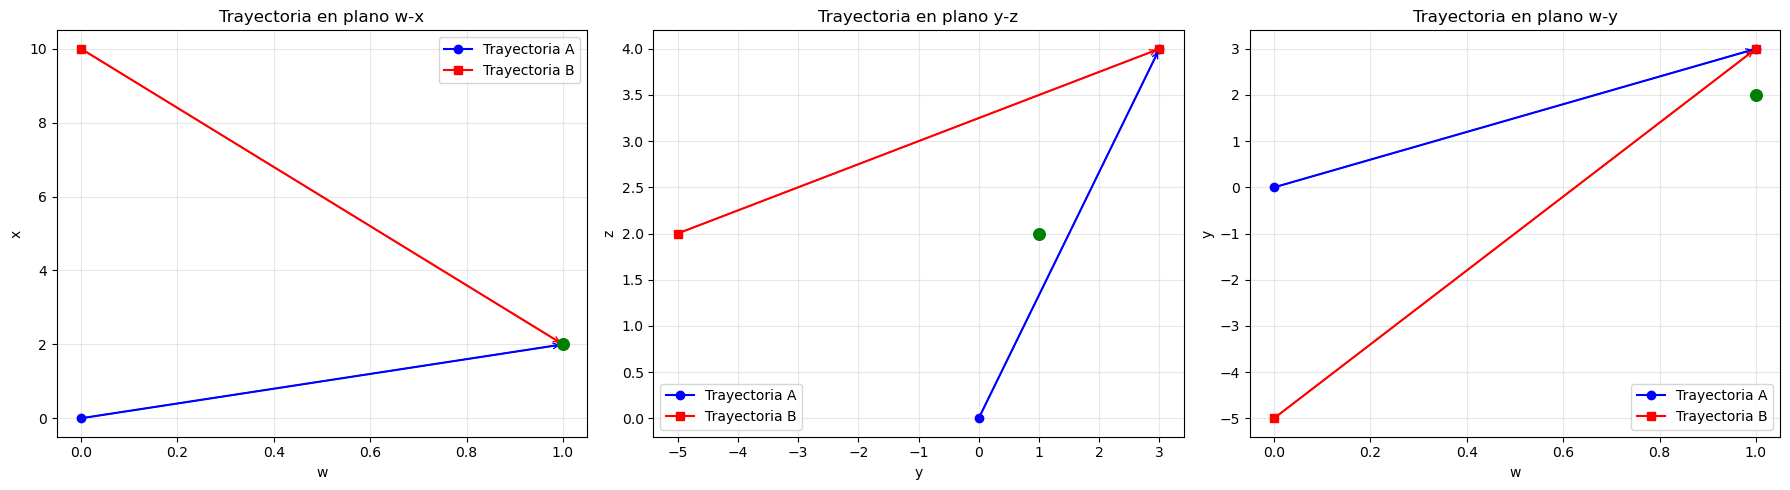

In [6]:
# Gráficas de proyecciones 2D de las trayectorias
import matplotlib.pyplot as plt

pairs = [(0,1,'w','x'), (2,3,'y','z'), (0,2,'w','y')]
trajA = np.array(res_a['trajectory'])
trajB = np.array(res_b['trajectory'])

fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax, (i,j,li,lj) in zip(axes, pairs):
    ax.plot(trajA[:,i], trajA[:,j], '-o', color='blue', label='Trayectoria A')
    ax.plot(trajB[:,i], trajB[:,j], '-s', color='red', label='Trayectoria B')
    # Flechas (solo si más de 1 paso)
    for T,color in [(trajA,'blue'), (trajB,'red')]:
        for k in range(len(T)-1):
            ax.annotate('', xy=(T[k+1,i], T[k+1,j]), xytext=(T[k,i], T[k,j]),
                        arrowprops=dict(arrowstyle='->', color=color, lw=1.0))
    ax.scatter([1],[2], color='green', s=70, zorder=5)  # componente w vs x (o w vs y etc.)
    ax.set_xlabel(li)
    ax.set_ylabel(lj)
    ax.set_title(f'Trayectoria en plano {li}-{lj}')
    ax.grid(alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

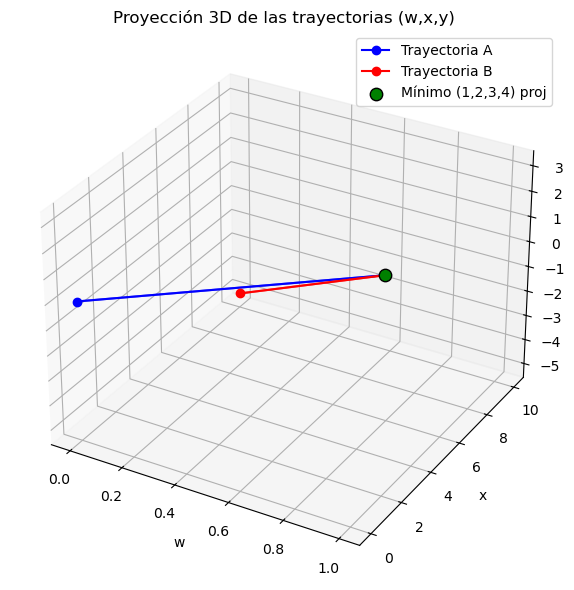

In [7]:
# Proyección 3D en espacio (w,x,y) coloreada por iteración
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for traj, color, label in [(trajA, 'blue', 'A'), (trajB, 'red', 'B')]:
    ax.plot(traj[:,0], traj[:,1], traj[:,2], marker='o', color=color, label=f'Trayectoria {label}')
    for k in range(len(traj)-1):
        ax.plot(traj[k:k+2,0], traj[k:k+2,1], traj[k:k+2,2], color=color, alpha=0.6)

ax.scatter([1],[2],[3], color='green', s=80, edgecolor='black', label='Mínimo (1,2,3,4) proj')
ax.set_xlabel('w')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_title('Proyección 3D de las trayectorias (w,x,y)')
ax.legend()
plt.tight_layout()
plt.show()

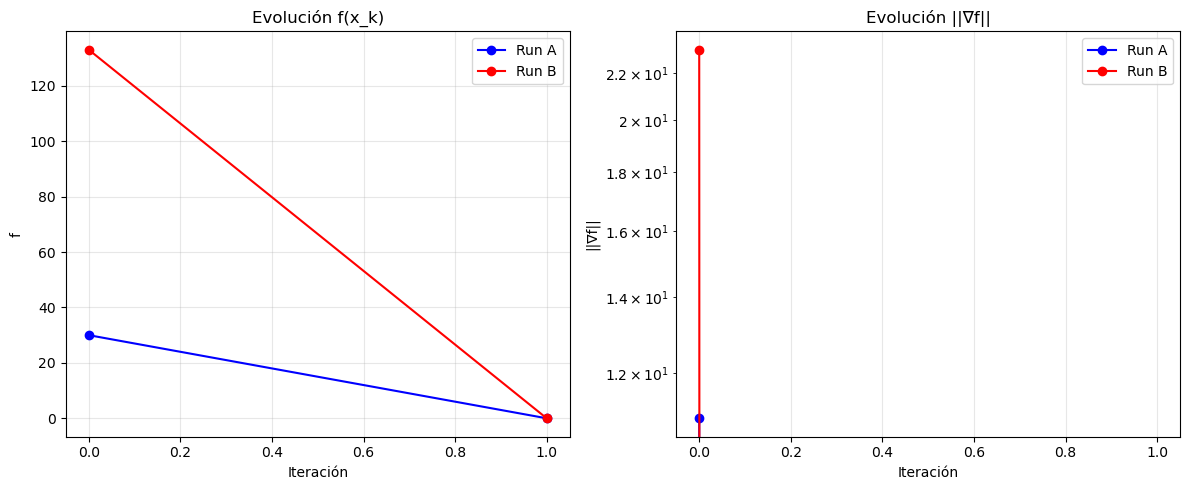

In [8]:
# Gráficas de convergencia f(x_k) y ||grad||
fig, axes = plt.subplots(1,2, figsize=(12,5))
for res,label,color in [(res_a,'A','blue'), (res_b,'B','red')]:
    axes[0].plot(range(len(res['f_values'])), res['f_values'], '-o', color=color, label=f'Run {label}')
    axes[1].plot(range(len(res['grad_norms'])), res['grad_norms'], '-o', color=color, label=f'Run {label}')

axes[0].set_title('Evolución f(x_k)')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('f')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].set_title('Evolución ||∇f||')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('||∇f||')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## Análisis y Discusión
El problema considerado es una función cuadrática estrictamente convexa con Hessiana constante $H = 2I_4$. Esto conlleva:

- Convergencia en **una sola iteración** teórica desde cualquier punto inicial, porque la actualización de Newton salta directamente al mínimo exacto.
- Número de condición $\kappa(H)=1$, lo que evita amplificación de errores numéricos.
- Las diferencias observadas en el número de iteraciones (si las hubiera) provendrían únicamente de la tolerancia y de efectos de redondeo.

### Sensibilidad al punto inicial
Para funciones cuadráticas con Hessiana constante e invertible, el punto inicial no afecta el número de iteraciones (una). En funciones no cuadráticas, un mal punto inicial puede:
- Llevar a regiones con Hessiana indefinida (direcciones de ascenso/descenso mezcladas).
- Aumentar el número de iteraciones por mala aproximación cuadrática local.

### Coste computacional
En dimensión 4 el coste es bajo ($O(n^3)$ para invertir Hessiana). En dimensiones grandes:
- El cálculo explícito e inversión de Hessiana puede ser prohibitivo.
- Se utilizan variantes (Quasi-Newton, BFGS, L-BFGS) o métodos de Hessiana-vector (Newton truncado).

### Manejo de singularidad
Se implementó lógica para:
- Usar pseudo-inversa si $H$ es singular o mal condicionada.
- Regularizar añadiendo $\lambda I$ en caso necesario.
Esto es crucial en problemas reales donde la Hessiana puede degenerar.


## Conclusiones y Extensiones
El método de Newton-Raphson aplicado a esta función cuadrática en $\mathbb{R}^4$ alcanza el mínimo teórico $\mathbf{x}^*=(1,2,3,4)$ en un único paso debido a la estructura ideal (Hessiana constante y bien condicionada).

### Puntos clave
- La implementación general permite reutilizarse en funciones no cuadráticas sin modificaciones estructurales.
- El manejo de singularidad (pseudo-inversa / regularización) añade robustez.
- Las trayectorias desde puntos iniciales distintos colapsan rápidamente al óptimo.

### Posibles Extensiones
1. Reemplazar la función por una no lineal acoplada, por ejemplo:
   $$g(w,x,y,z) = (w-1)^2 + (x - w^2)^2 + (y - x^2)^2 + (z - y^2)^2.$$
2. Comparar desempeño con descenso por gradiente y BFGS.
3. Analizar sensibilidad numérica introduciendo ruido en evaluaciones de $f$ o $\nabla f$.
4. Implementar criterio adaptativo para alternar entre inversa y pseudo-inversa.

**Conclusión:** El caso estudiado confirma el comportamiento ideal del método en funciones cuadráticas fuertemente convexas y sienta la base para explorar escenarios más desafiantes donde la Hessiana varía y el condicionamiento impacta la convergencia.
